<table border=0px>
<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/HuffPost.svg/320px-HuffPost.svg.png">
</td>
<td>
<img src="https://upload.wikimedia.org/wikipedia/en/thumb/a/ae/Flag_of_the_United_Kingdom.svg/320px-Flag_of_the_United_Kingdom.svg.png">
</td>
</tr>
</table>

# Analyse des sources de l'édition britannique du *Huff Post* (2011-2016) en 6 étapes faciles
<hr>

<h3 style="background:teal;color:white;padding:5px">Étape 1 - Initialisation de notre <i>notebook</i> et lecture du fichier CSV contenant nos données</h3>

In [1]:
import csv, re, random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 999
pd.options.mode.chained_assignment = None
%matplotlib inline

On lit notre fichier CSV de base, puis on crée une variable `edition` pour identifier le pays sur lequel on va travailler. La variable `huff` ne contient que les articles de l'édition du pays auquel on s'intéresse ici.

In [2]:
huff = pd.read_csv("scraping-nettoye.csv", low_memory=False)
edition = "Royaume-Uni"
huff = huff[huff.pays == edition]
huff.shape

(161263, 13)

Le but de cet exercice étant d'identifier le taux d'originalité du *HuffPost*, on va créer trois variables.

- `HP_oui` contiendra la proportion d'articles qui sont originaux (signés par des employés du *HuffPost* ou des pigistes).
- `HP_non` contiendra la proportion d'articles qui ne sont pas originaux (repris d'agences externes ou d'autres médias).
- `HP_inconnu` contiendra la proportion d'articles dont on ne peut pas établir la provenance.

La somme de ces trois variables équivaudra à 100. On s'en servira pour faire un graphique en pointes de tarte (camembert) à la fin.

In [3]:
HP_oui = 0
HP_non = 0
HP_inconnu = 0

<h3 style="background:teal;color:white;padding:5px">Étape 2 - Filtrer les balises <i>meta</i></h3>

<hr>
Ce ne sont pas tous les articles de cette édition du *Huff Post* qui ont, pour nom dans leurs balises `meta`, l'une ou l'autre des éditions du *Huffington Post*, ou de sa compagnie-mère, AOL

In [4]:
huff.meta.value_counts()

The Huffington Post       161250
The Huffington Post UK    9     
Le Huffington Post        2     
허핑턴포스트                    1     
Recipes at Sainsbury's    1     
Name: meta, dtype: int64

Créons un sous-ensemble avec les articles qui, selon la balise `meta`, semblent issus du *HP*.

In [5]:
metaHP = huff.meta.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]", na=False)
huff[metaHP].meta.value_counts()

The Huffington Post       161250
The Huffington Post UK    9     
Le Huffington Post        2     
허핑턴포스트                    1     
Name: meta, dtype: int64

In [6]:
huff[metaHP].shape

(161262, 13)

In [7]:
len(huff) - len(huff[metaHP])

1

Le calcul ci-haut nous indique que la balise `meta` des articles du *HuffPost&nbsp;UK* donne à penser qu'**un seul article** n'a pas été rédigé par l'équipe maison.
<hr>
Examinons-les quand même de plus près en regardant qui sont les signataires de l'ensemble de ces articles. Les signataires se trouvent dans la colonne `byline`. Voyons voir, donc, ce qu'elle contient.

<h3 style="background:teal;color:white;padding:5px">Étape 3 - Identification des articles dont les signataires sont inconnus</h3>

In [8]:
huff[metaHP].byline.value_counts()

The Huffington Post UK ?                                                                                                                                                                                                                                                                                                                                    20842
PA ?                                                                                                                                                                                                                                                                                                                                                        12613
 ?                                                                                                                                                                                                                                                                                                  

Un certain nombre d'auteurs sont inconnus («&nbsp;?&nbsp;» ou «&nbsp;?&nbsp;?&nbsp;»).<br>
Ceux marqués d'un seul point d'interrogation seront placés dans le sous-ensemble `inconnu1`, ceux qui sont marqués de deux points d'interrogation dans le sous-ensemble `inconnu2`.<br>
Ils représentent à peine **0,1%** du total des articles de cette édition du *Huffington&nbsp;Post*.<br>
Nous allons placer cette proportion dans notre variable `HP_inconnu`.

In [9]:
inconnus1 = huff[metaHP].byline == "? "
inconnus2 = huff[metaHP].byline == "? ?"
HP_inconnu = huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()
HP_inconnu, (HP_inconnu/len(huff))*100

(189, 0.11719985365520919)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 4 - Identification des articles originaux au <i>HuffPost</i></h3>

Examinons maintenant les articles dont la signature contient certaines chaînes de caractères qui correspondent au *Huffington Post* (dans différentes langues, fautes de frappe incluses), ou à sa compagnie-mère, AOL. On va baptiser ce sous-ensemble `signéHP`.

In [10]:
signeHP = huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][signeHP].shape

(110464, 13)

In [11]:
huff[metaHP][signeHP].byline.value_counts(), huff[metaHP][signeHP].byline.value_counts().count()

(The Huffington Post UK ?                                                                                                                                                                                                                                   20842
 Huffington Post UK ?                                                                                                                                                                                                                                       4059 
 PA/The Huffington Post UK ?                                                                                                                                                                                                                                3989 
 Sara C Nelson\n\n\n\n\nSenior Editor, The Huffington Post UK Senior Editor, The Huffington Post UK                                                                                                                               

Le *Huffington Post* est nommé, d'une façon ou d'une autre, dans ces quelque **110&nbsp;464 articles** signés par **1&nbsp;273 signataires différents**.<br>
Cela représente plus des **deux tiers** de l'ensemble des articles publiés par l'édition britannique du *HuffPost* dans la période étudiée.
On peut placer cette proportion dans notre variable `HP_oui`.

In [12]:
HP_oui = huff[metaHP][signeHP].pays.count()
HP_oui, (HP_oui/len(huff))*100

(110464, 68.499283778672108)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 5 - Identification des articles <u>extérieurs</u> au <i>HuffPost</i></h3>

On va donc faire la même opération, mais pour tous les postes dans lesquels **on ne trouve pas** les chaînes de caractères permettant d'identifier le *Huffington&nbsp;Post* dans différentes langues. On va créer un nouveau sous-ensemble qu'on va baptiser `NONsignéHP`.

In [13]:
NONsigneHP = ~huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][NONsigneHP].shape

(50798, 13)

Qui sont ces auteurs qui ne signent pas des articles originaux pour le *HuffPost*?

In [14]:
huff[metaHP][NONsigneHP].byline.value_counts(), huff[metaHP][NONsigneHP].byline.value_counts().count() 

(PA ?                                                                                                                                                                                                                                                                                                                                                        12613
  ?                                                                                                                                                                                                                                                                                                                                                          6073 
 Samuel Luckhurst\n\n\n\n\nFootball writer, The Manchester Evening News Football writer, The Manchester Evening News                                                                                                                                                                              

Des 123 signataires ci-dessus, par contre, on trouve plusieurs «&nbsp;employés fantôme&nbsp;». Ils comprennent, dans leur signature, les mots *«&nbsp;Editor&nbsp;»*, *«&nbsp;Reporter&nbsp;»* ou *«&nbsp;Journalist&nbsp;»*, par exemples.
Isolons-les.

In [15]:
fantomes = huff[metaHP][NONsigneHP].byline.str.contains("[E,e]ditor|[P,p]roducer|[R,r]eporte")
huff[metaHP][NONsigneHP][fantomes].byline.value_counts(), huff[metaHP][NONsigneHP][fantomes].byline.value_counts().sum()

(Rachel McGrath\n\n\n\n\nEditorial Assistant, Entertainment Editorial Assistant, Entertainment                                                                                                                                                                                                                                                               2356
 Daniel Welsh\n\n\n\n\nEntertainment Reporter Entertainment Reporter                                                                                                                                                                                                                                                                                         1081
 Ash Percival\n\n\n\n\nEntertainment Reporter Entertainment Reporter                                                                                                                                                                                                                                

Ces auteurs ont donc signé **7&nbsp;853 articles** (7&nbsp;918 articles ci-dessus, auxquels il faut retrancher les 51 articles rédigés par des auteurs de la **[Press Association](https://www.pressassociation.com/)**, une agence de presse britannique, les 9 articles du *Hollywood Reporter* et le 5 articles du *Google Insider*.

On peut les ajouter à notre variable `HP_oui`.

In [16]:
HP_oui = huff[metaHP][signeHP].pays.count() + 7853
HP_oui, (HP_oui/len(huff))*100

(118317, 73.36896870329835)

Pour calculer le pourcentage des articles signés par des auteurs externes, il faut soustraire de notre sous-ensemble `NONsignéHP` les articles contenus dans les deux sous-ensembles `inconnu1` et `inconnu2`, et additionner les articles qu'on a identifié plus haut dont la balise `meta` ne pouvait pas être associée au *HuffPost*, puis retrancher tous les articles qu'on vient de ranger dans notre variable `HP_oui`.

In [17]:
HP_non = huff[metaHP][NONsigneHP].pays.count() - (huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()) + (len(huff) - len(huff[metaHP])) - 7853
HP_non, (HP_non/len(huff))*100

(42757, 26.513831443046453)

On a désormais tout ce qu'il nous faut pour faire le camembert évoqué plus haut.

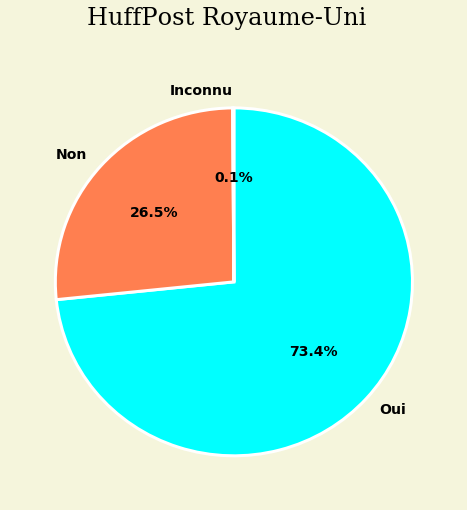

In [18]:
camembert = pd.Series([HP_oui,HP_non,HP_inconnu], index=["Oui","Non","Inconnu"],name="")
titre = plt.figure(facecolor="beige")
titre.suptitle("HuffPost Royaume-Uni", fontsize=24, fontweight="light", fontname="Serif")
camembert.plot.pie(colors=["aqua","coral","lightgrey"],
                   wedgeprops={"linewidth":3,"edgecolor":"white"},
                   textprops={"weight":"bold","fontsize":14},
                   counterclock=False,
                   startangle=90,
                   autopct="%1.1f%%",
                   figsize=(8,8)
)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 6 - Exercice boni&nbsp;: les étiquettes (<i>tags</i>)</h3>

Chaque article du *Huffington Post* est généralement accompagné d'une dizaine de marqueurs, ou d'étiquettes (*tags* en anglais). Voici ceux qui sont le plus fréquemment utilisés par cette édition.

In [19]:
etiquettes = huff.set_index('pays').tags.str.split(',', expand=True).stack().rename(columns={0:'tag'}).reset_index(drop=True)
etiquettes.value_counts(dropna=False)

uk news                                              56572
uk celebrity                                         14516
video                                                14249
uktv                                                 9561 
uk lifestyle                                         8238 
UK Sport                                             7181 
UK Lifestyle News                                    6185 
UK Politics                                          5233 
david cameron                                        5065 
UK football                                          4802 
uk viral videos                                      4613 
UK crime                                             4050 
uk parents                                           3974 
UK business                                          3849 
uk tech                                              3442 
uk students                                          3217 
slideexpand                                          314